In [8]:
import numpy as np
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit
from qiskit.quantum_info import (
    DensityMatrix,
    Statevector,
    concurrence
)

from qiskit_aer import AerSimulator
from qiskit_aer.noise import (
    NoiseModel,
    depolarizing_error,
    amplitude_damping_error
)


In [9]:
def create_bell_circuit():
    qc = QuantumCircuit(2)
    qc.h(0)
    qc.cx(0, 1)
    return qc


In [10]:
def simulate_noisy_density_matrix(noise_model):
    sim = AerSimulator(
        noise_model=noise_model,
        method="density_matrix"
    )
    
    qc = create_bell_circuit()
    qc.save_density_matrix()
    
    result = sim.run(qc).result()
    rho = result.data(0)["density_matrix"]
    
    return DensityMatrix(rho)


In [11]:
def ibm_noise_model(p):
    noise = NoiseModel()
    
    error_1q = depolarizing_error(p, 1)
    error_2q = depolarizing_error(2*p, 2)
    
    noise.add_all_qubit_quantum_error(error_1q, ["h"])
    noise.add_all_qubit_quantum_error(error_2q, ["cx"])
    
    return noise


In [12]:
def ionq_noise_model(p):
    noise = NoiseModel()
    
    error_1q = amplitude_damping_error(p)
    error_2q = amplitude_damping_error(1.5*p).tensor(
        amplitude_damping_error(1.5*p)
    )
    
    noise.add_all_qubit_quantum_error(error_1q, ["h"])
    noise.add_all_qubit_quantum_error(error_2q, ["cx"])
    
    return noise


In [13]:
noise_levels = np.linspace(0, 0.25, 10)

conc_ibm = []
conc_ionq = []

for p in noise_levels:
    dm_ibm = simulate_noisy_density_matrix(ibm_noise_model(p))
    dm_ionq = simulate_noisy_density_matrix(ionq_noise_model(p))
    
    conc_ibm.append(concurrence(dm_ibm))
    conc_ionq.append(concurrence(dm_ionq))


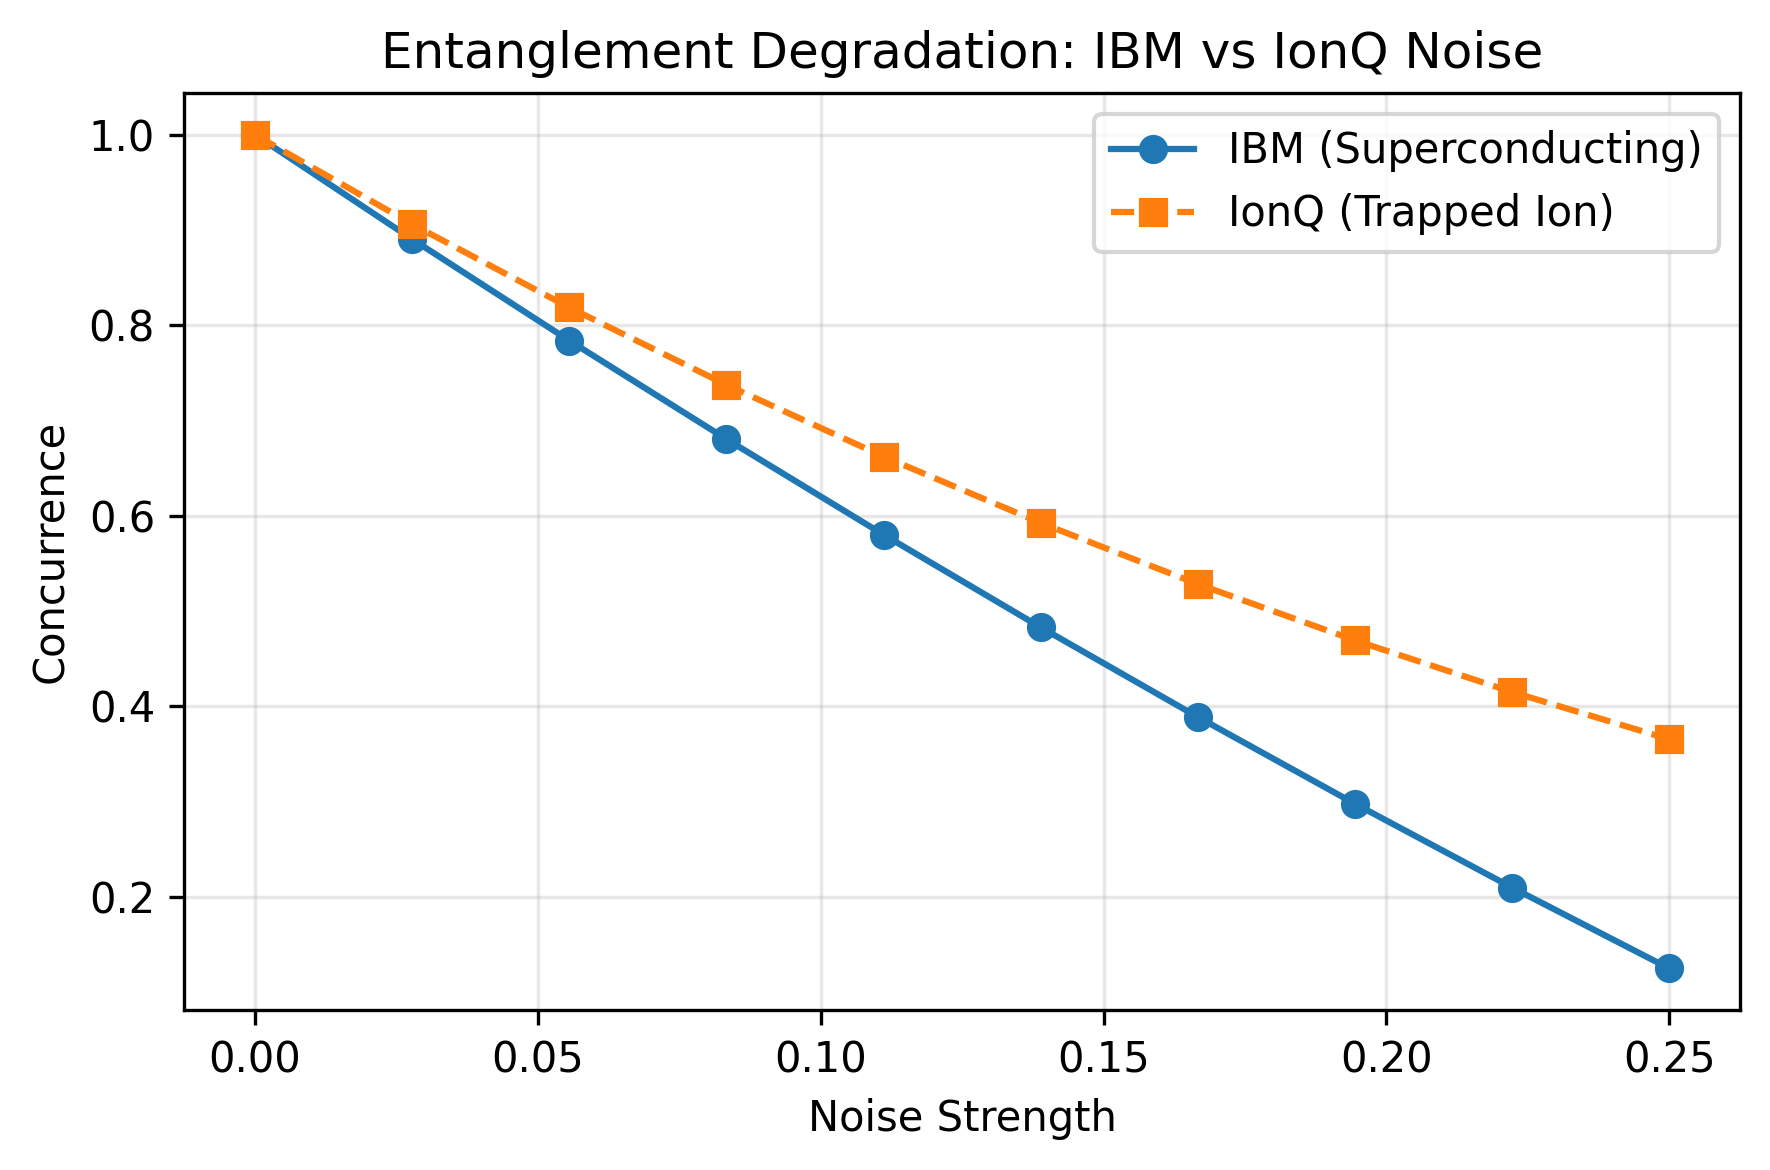

In [14]:
plt.figure(figsize=(6,4), dpi=300)

plt.plot(noise_levels, conc_ibm, 'o-', label="IBM (Superconducting)")
plt.plot(noise_levels, conc_ionq, 's--', label="IonQ (Trapped Ion)")

plt.xlabel("Noise Strength")
plt.ylabel("Concurrence")
plt.title("Entanglement Degradation: IBM vs IonQ Noise")

plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.savefig("../results/hardware_comparison.png")
plt.show()
